In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as pl
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.metrics import accuracy_score


In [2]:
df = pd.read_csv('sap_storing_data_hu_project.csv')


df.drop_duplicates(subset ="#stm_sap_meldnr",
                     keep = False, inplace = True)

C:\Users\emiel\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,11,19,21,24,25,27,32,33,36,37,38,39,40,46,47,48,49,51,53,55,56,60,73,75,78,80,82,83,86,87,91,95,99,102,103,104,107,108,109,110,111,112,113,116,118,119,120,121,122,123,124,129) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
def column_outlier(strength, dataframe, columns):
    temp_dataframe = dataframe.copy()
    try:
        if strength == 's':
            strength=3
        elif strength == 'a':
            strength=1.5
    except:
        print("Invalid strength")
    for column in columns:
        Q1 = temp_dataframe[column].quantile(0.25)
        Q3 = temp_dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        temp_dataframe = temp_dataframe[~((temp_dataframe[column] < (Q1 - strength * IQR)) |(temp_dataframe[column] > (Q3 + strength* IQR)))]
    return temp_dataframe

In [4]:
def get_accuracy(r,zip_list):
    return len([ _ for x in zip_list if x[0]+r >= x[1] >= x[0]-r])/len(zip_list)

<h2>Data Cleaning </h2>

In [5]:
# we willen alleen durations die niet gelijk zijn aan 0 en kleiner zijn dan 8 uur
df = df[(df.stm_fh_duur != 0) & (df.stm_fh_duur <= 480)]

# ik zorg er hier voor dat de 'stm_progfh_in_duur' kolom naar floats gecast wordt
df.stm_progfh_in_duur = df.stm_progfh_in_duur.apply(lambda x: float(str(x).replace('-','').replace('*','').strip()))

# delete stm_fh_duur outliers
#df = column_outlier('a', df.copy(), ['stm_fh_duur'])


# voeg dummy kolommen voor seizoenen toe
df.stm_sap_melddatum = pd.to_datetime(df.stm_sap_melddatum)

df['date_offset'] = (df.stm_sap_melddatum.dt.month*100 + df.stm_sap_melddatum.dt.day - 320)%1300

df['seizoen_melding'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                      labels=['spring', 'summer', 'autumn', 'winter'])

df.drop(['date_offset'], axis=1)
df = df.join(pd.get_dummies(df.seizoen_melding))

# join de oorzaakcodes
o_df = pd.read_csv('Oorzaakcodes.csv', sep = ';')
o_df = o_df.rename(columns={'Code': 'stm_oorz_code'})
df = df.merge(o_df, on = 'stm_oorz_code', how = 'outer')

# join de goetrajectcodes
geo_df = pd.read_csv('geocodes.csv',sep = ';') 
geo_df = geo_df.rename(columns={'Code': 'stm_geo_mld'})
df = df.merge(geo_df, on = 'stm_geo_mld', how = 'outer') 

# join de Contractgebiedcodes
cg = pd.read_excel('Contractgebiedcodes.xlsx') #Contract gebied storing
cg = cg.rename(columns={'Code': 'stm_contractgeb_gst'})
df = df.merge(cg, on = 'stm_contractgeb_gst', how = 'outer')



# maak target var bins zodat we classification kunnen gebruiken
error_margin  = 5
bins = [x for x in range(0,480,error_margin)]
labels = [x for x in range(1,len(bins))]
df['duration_bin'] = pd.cut(df['stm_fh_duur'], bins = bins, labels=labels)



# kolom voor meltijd h
df['meldtijd_h'] = df.stm_sap_meldtijd.str.split(':').str[0]


In [6]:
pd.set_option('display.max_rows', None)

In [7]:
pd.set_option('display.max_columns', None)

<AxesSubplot:xlabel='stm_fh_duur', ylabel='Density'>

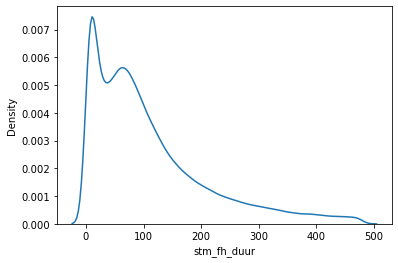

In [8]:
sns.kdeplot(df.stm_fh_duur)

In [9]:
mean_durgeo_df = column_outlier('a', df.copy(), ['stm_fh_duur'])[['stm_fh_duur', 'Traject']].groupby('Traject', as_index = False).mean()
mean_durgeo_df

,Traject,stm_fh_duur
0,Aachen (D) - Herzogenrath (D),NaN
1,Alkmaar,31.826087
2,Alkmaar - Uitgeest,NaN
3,Almelo,NaN
4,Almelo - Hengelo,NaN
5,Almelo Dollegoor,NaN
6,Almelo Gem. Stamlijn,NaN
7,Alphen a/d Rijn,NaN
8,Alphen a/d Rijn - Leiden Centraal,283.000000
9,Alphen a/d Rijn Industrieterrein Rijnhaven,NaN


<AxesSubplot:xlabel='stm_fh_duur', ylabel='Traject'>

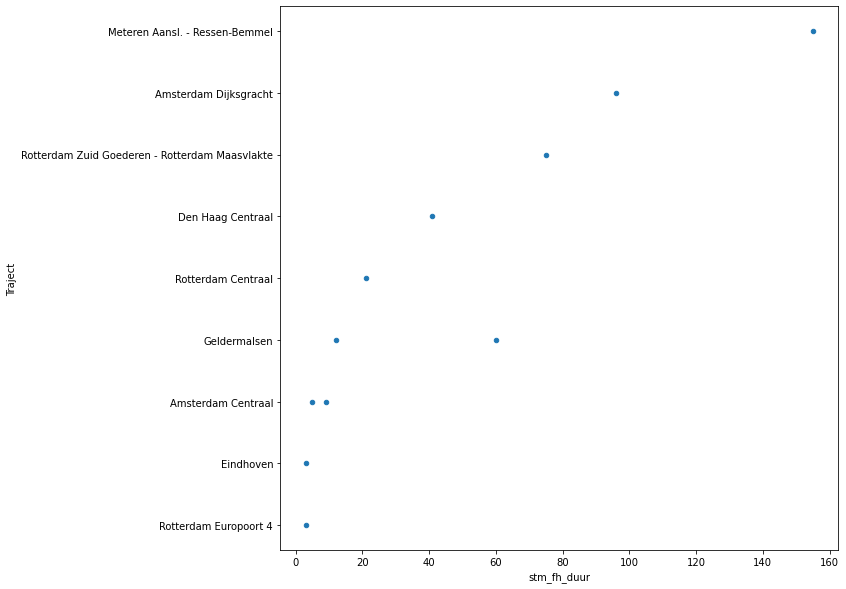

In [10]:
x = 'stm_fh_duur'
y = 'Traject'

tplot = df.sample(4000)[[x, y]]
tplot.sort_values(['stm_fh_duur'], ascending=True, inplace=True)
tplot.dropna(inplace=True)

tplot.plot(x=x, y=y, kind='scatter',figsize=(10,10))

C:\Users\emiel\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
<ipython-input-11-89b5bd9a5ab2>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


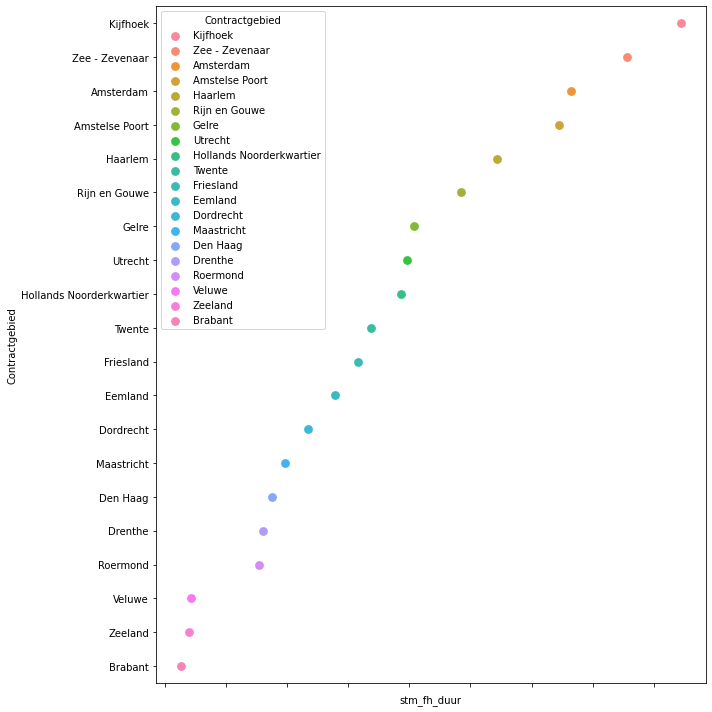

In [11]:
mean_cg_df = column_outlier('a', df.copy(), ['stm_fh_duur'])[['stm_fh_duur', 'Contractgebied']].groupby('Contractgebied', as_index = False).mean()
plt.figure(figsize=(10,10))
new_data= mean_cg_df.sort_values(by ='stm_fh_duur' , ascending=False)
new_data_sort=new_data.head(20)
ax=sns.pointplot(new_data_sort['stm_fh_duur'], new_data_sort['Contractgebied'], hue=new_data_sort['Contractgebied'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()


<h2> MODEL COMPARISON </h2>

In [28]:
# svm, random forests en gaussion process classifier duren veels te lang op deze dataset

dt_df = df.copy()[['duration_bin', 'stm_equipm_nr_mld','stm_reactie_duur', 'stm_prioriteit', 'stm_km_tot_mld', 'stm_km_van_mld','spring', 'summer','autumn','winter']].dropna()


dt_df = dt_df.join(pd.get_dummies(df.stm_contractgeb_gst)).dropna()
dt_df = dt_df.join(pd.get_dummies(df.meldtijd_h)).dropna()
dt_df = dt_df.join(pd.get_dummies(df.Oorzaak)).dropna()




X = dt_df.drop(columns = ['duration_bin'])
y = dt_df['duration_bin']



X_train_dt, X_test_dt, y_train_dt, y_test_dt = train_test_split(X, y, test_size=0.2)

#c = GridSearchCV(DecisionTreeClassifier(random_state = 0), {'max_depth' : [84,300,301,302,303,304]})
#clf = c.fit(X_train_dt, y_train_dt)

clf = DecisionTreeClassifier(max_depth = 84, random_state = 0).fit(X_train_dt, y_train_dt)
y_pred_dt = clf.predict(X_test_dt)


y1_ax = [get_accuracy(x, list(zip(list(y_test_dt), y_pred_dt))) for x in range(0,30)]

accuracy_score(y_test_dt,y_pred_dt)

0.10446591138984422

In [13]:
# svm, random forests en gaussion process classifier duren veels te lang op deze dataset

kn_df = df[['duration_bin','stm_equipm_nr_mld','stm_reactie_duur', 'stm_prioriteit', 'stm_km_tot_mld', 'stm_rapportage_jaar','spring', 'summer','autumn','winter']].dropna()

X = kn_df.drop(columns = ['duration_bin'])
y = kn_df.duration_bin


X_train_kn, X_test_kn, y_train_kn, y_test_kn = train_test_split(X, y, test_size=0.2)

clf2 = KNeighborsClassifier(n_neighbors = 1).fit(X_train_kn, y_train_kn)

y_pred_kn = clf2.predict(X_test_kn)

y2_ax = [get_accuracy(x, list(zip(list(y_test_kn), y_pred_kn))) for x in range(0,30)]

accuracy_score(y_test_kn,y_pred_kn)

0.07685110256928991

In [14]:
# vergelijk prorail prognose van hersteltijd met daadwerkelijke hersteltijd
bins = [x for x in range(0,480,error_margin)]
labels = [x for x in range(1,len(bins))]
prog_df = df.copy()[['stm_progfh_in_duur','duration_bin']]
prog_df = column_outlier('a', prog_df.copy(), ['stm_progfh_in_duur'])
prog_df['prog_duration_bin'] = pd.cut(prog_df['stm_progfh_in_duur'], bins = bins, labels=labels)
prog_df = prog_df.dropna()
prog_df = prog_df[['duration_bin', 'prog_duration_bin']]

y3_ax = [get_accuracy(x, list(zip(list(prog_df.duration_bin), list(prog_df.prog_duration_bin)))) for x in range(0,30)]

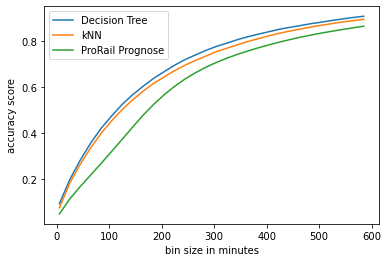

In [15]:
x_ax = [error_margin +(20*x) for x in range(0,30)]


plt.plot(x_ax,y1_ax, label = 'Decision Tree')
plt.plot(x_ax,y2_ax, label = 'kNN')
plt.plot(x_ax,y3_ax, label = 'ProRail Prognose')


plt.xlabel('bin size in minutes')
plt.ylabel('accuracy score')

plt.legend()
plt.show()

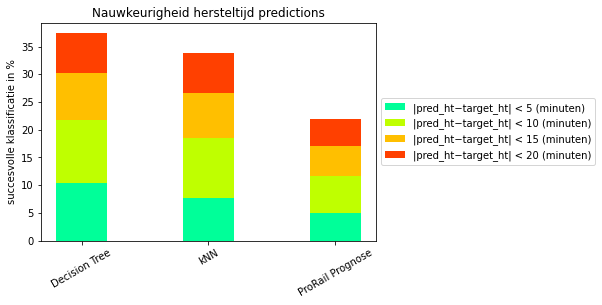

In [29]:
labels = ['Decision Tree', 'kNN', 'ProRail Prognose']

bar_1 = [100 * eval(f"y{i}_ax[0]") for i in range(1,len(labels)+1)]
bar_2 = [100 * (eval(f"y{i}_ax[1]") - eval(f"y{i}_ax[0]")) for i in range(1,len(labels)+1)]
bar_3 = [100 * (eval(f"y{i}_ax[2]") - eval(f"y{i}_ax[1]")) for i in range(1,len(labels)+1)]
bar_4 = [100 * (eval(f"y{i}_ax[3]") - eval(f"y{i}_ax[2]")) for i in range(1,len(labels)+1)]

width = 0.4  

fig, ax = plt.subplots()

ax.bar(labels, bar_1, width, label=f'|pred_ht−target_ht| < {error_margin} (minuten)', color = '#00ff99')
ax.bar(labels, bar_2, width ,bottom=bar_1,label=f'|pred_ht−target_ht| < {2*error_margin} (minuten)', color = '#bfff00')
ax.bar(labels, bar_3, width ,bottom=(np.array(bar_2) + np.array(bar_1)),label=f'|pred_ht−target_ht| < {3*error_margin} (minuten)', color = '#ffbf00')
ax.bar(labels, bar_4, width ,bottom=(np.array(bar_2) + np.array(bar_1) + np.array(bar_3)),label=f'|pred_ht−target_ht| < {4*error_margin} (minuten)', color = '#ff4000')


ax.set_ylabel('succesvolle klassificatie in %')
ax.set_title('Nauwkeurigheid hersteltijd predictions')

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xticks(rotation=30)

plt.show()

In [17]:
list(X_train_dt.columns)

['stm_equipm_nr_mld',
 'stm_reactie_duur',
 'stm_prioriteit',
 'stm_km_tot_mld',
 'stm_km_van_mld',
 'spring',
 'summer',
 'autumn',
 'winter',
 0.0,
 1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0,
 16.0,
 17.0,
 18.0,
 19.0,
 20.0,
 21.0,
 22.0,
 23.0,
 24.0,
 25.0,
 26.0,
 27.0,
 28.0,
 29.0,
 30.0,
 31.0,
 32.0,
 33.0,
 34.0,
 35.0,
 36.0,
 37.0,
 50.0,
 51.0,
 52.0,
 53.0,
 54.0,
 55.0,
 56.0,
 57.0,
 58.0,
 59.0,
 60.0,
 61.0,
 62.0,
 63.0,
 64.0,
 70.0,
 71.0,
 81.0,
 82.0,
 83.0,
 99.0,
 '',
 '00',
 '01',
 '02',
 '03',
 '04',
 '05',
 '06',
 '07',
 '08',
 '09',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23']

In [18]:
list(X_train_kn.columns)

['stm_equipm_nr_mld',
 'stm_reactie_duur',
 'stm_prioriteit',
 'stm_km_tot_mld',
 'stm_rapportage_jaar',
 'spring',
 'summer',
 'autumn',
 'winter']

In [19]:
# base chance for a right classification by guessing the most common bin
max(df.duration_bin.dropna().value_counts())/len(df.duration_bin.dropna())

0.05443204757817883

In [20]:
# decision tree
[eval(f"y1_ax[{i}]") for i in range(4)]

[0.0949322273922719,
 0.20000505765729315,
 0.2841897633016387,
 0.3586131903702205]

In [21]:
# kNN
[eval(f"y2_ax[{i}]") for i in range(4)]

[0.07685110256928991,
 0.18518612178838761,
 0.2664879627756423,
 0.33818025490592757]

In [22]:
# prorail prognose
[eval(f"y3_ax[{i}]") for i in range(4)]

[0.05045674083422283,
 0.11601629995695019,
 0.16972241715859435,
 0.2197781460273278]

In [23]:
df.head()

,Unnamed: 0,#stm_sap_meldnr,stm_mon_nr,stm_vl_post,stm_sap_meld_ddt,stm_sap_mon_meld_ddt,stm_sap_meldtekst_lang,stm_mon_begin_ddt,stm_sap_meldtekst,stm_mon_toelichting_trdl,stm_oh_pg_mld,stm_geo_mld,stm_geo_mld_uit_functiepl,stm_equipm_nr_mld,stm_equipm_soort_mld,stm_equipm_omschr_mld,stm_km_van_mld,stm_km_tot_mld,stm_prioriteit,stm_scenario_mon,stm_status_melding_sap,stm_mon_nr_status_omschr,stm_mon_nr__statuscode,stm_mon_nr_status_wijzdd,stm_aanngeb_ddt,stm_aanntpl_ddt,stm_oh_pg_gst,stm_geo_gst,stm_geo_gst_uit_functiepl,stm_equipm_nr_gst,stm_equipm_soort_gst,stm_equipm_omschr_gst,stm_objectdl_code_gst,stm_objectdl_groep_gst,stm_km_van_gst,stm_km_tot_gst,stm_progfh_in_ddt,stm_progfh_in_invoer_ddt,stm_progfh_gw_ddt,stm_progfh_gw_lwd_ddt,stm_progfh_hz,stm_oorz_groep,stm_oorz_code,stm_oorz_tkst,stm_veroorz_groep,stm_veroorz_code,stm_veroorz_tekst_kort,stm_effect,stm_afspr_aanvangddt,stm_fh_ddt,stm_fh_status,stm_sap_storeind_ddt,stm_mon_eind_ddt,stm_mon_vhdsincident,stm_tao_indicator,stm_tao_indicator_vorige,stm_tao_soort_mutatie,stm_tao_telling_mutatie,stm_tao_beinvloedbaar_indicator,stm_evb,stm_dir_betrok_tr,stm_aangelegd_dd,stm_aangelegd_tijd,stm_sap_melddatum,stm_sap_meldtijd,stm_mon_begindatum,stm_mon_begintijd,stm_contractgeb_mld,stm_functiepl_mld,stm_techn_mld,stm_contractgeb_gst,stm_functiepl_gst,stm_techn_gst,stm_aanngeb_dd,stm_aanngeb_tijd,stm_aanntpl_dd,stm_aanntpl_tijd,stm_arbeid,stm_progfh_in_datum,stm_progfh_in_tijd,stm_progfh_in_invoer_dat,stm_progfh_in_invoer_tijd,stm_progfh_in_duur,stm_progfh_gw_datum,stm_progfh_gw_tijd,stm_progfh_gw_lwd_datum,stm_progfh_gw_lwd_tijd,stm_progfh_gw_duur,stm_progfh_gw_teller,stm_afspr_aanvangdd,stm_afspr_aanvangtijd,stm_fh_dd,stm_fh_tijd,stm_fh_duur,stm_reactie_duur,stm_sap_storeinddatum,stm_sap_storeindtijd,stm_mon_eind_datum,stm_mon_eind_tijd,stm_controle_dd,stm_akkoord_mon_toewijz,stm_status_sapnaarmon,stm_fact_jn,stm_akkoord_melding_jn,stm_afsluit_ddt,stm_afsluit_dd,stm_afsluit_tijd,stm_rec_toegev_ddt,stm_hinderwaarde,stm_actie,stm_standplaats,stm_status_gebr,stm_wbi_nummer,stm_projnr,stm_oorz_tekst_kort,stm_historie_toelichting,stm_schade_verhaalb_jn,stm_schadenr,stm_schade_status_ga,stm_schade_statusdatum,stm_relatiervo_vorig,stm_relatiervo_volgend,stm_relatiervo,stm_pplg_van,stm_pplg_naar,stm_dstrglp_van,stm_dstrglp_naar,stm_afspr_func_hersteldd,stm_afspr_func_hersteltijd,stm_sorteerveld,stm_rapportage_maand,stm_rapportage_jaar,stm_x_bron_publ_dt,stm_x_bron_bestandsnaam,stm_x_bron_arch_dt,stm_x_actueel_ind,stm_x_run_id,stm_x_bk,stm_x_start_sessie_dt,stm_x_vervallen_ind,date_offset,seizoen_melding,spring,summer,autumn,winter,Oorzaak,Traject,Contractgebied,duration_bin,meldtijd_h
0,2,50053213.0,48.0,GN,02/01/2006 12:35:00,02/01/2006 12:35:00,Logboeknr RBV : 48 Tijd: 1235 VL-Post: ...,02/01/2006 12:35:00,Logboeknr RBV : 48 Tijd: 1235 VL-P,NaN,NaN,201.0,201.0,NaN,NaN,NaN,0.0,0.0,9.0,NaN,MAFS,Aan AM toegewezen,0.0,03/01/2006,02/01/2006 12:35:00,NaN,37B,201.0,201.0,NaN,NaN,NaN,NaN,NaN,30200.0,0.0,NaN,NaN,NaN,NaN,Z,ONR-DERD,143.0,NaN,ONREGDER,T,NaN,NaN,NaN,02/01/2006 13:26:00,4.0,02/01/2006 13:26:00,NaN,NaN,N,NaN,NaN,0.0,NB,"0,00",NaN,03/01/2006,05:50:40,2006-02-01,12:35:00,02/01/2006,12:35:00,NaN,201,NaN,37.0,201,B,02/01/2006,12:35:00,NaN,00:00:00,99999999.0,NaN,00:00:00,NaN,00:00:00,99999999.0,NaN,00:00:00,NaN,NaN,99999999.0,0.0,00/00/0000,00:00:00,02/01/2006,13:26:00,51.0,99999999.0,02/01/2006,13:26:00,NaN,NaN,10/01/2006,J,1.0,N,J,05/01/2009 15:10:11,05/01/2009,15:10:11,02/01/2006 05:50:40,0.85,NaN,NaN,IN0 H5,0000000000,NaN,schapen op de spoorbaan!,NaN,NaN,0.0,NaN,0.0,NaN,NaN,50053213.0,NaN,NaN,Lp,Apg,00/00/0000,00:00:00,NaN,1.0,2006.0,02/01/2006 12:35:00,\\PUHAPS0149\Informatica_Prod\Inbox\Informatic...,31/12/9999 00:00:00,1.0,1518.0,12704591.0,13/06/2013 13:37:52,0.0,1181.0,winter,0.0,0.0,0.0,1.0,"Dieren, schade door of (bijna) aanrijding",NaN,Friesland,11,12
1,3872,50059285.0,10216.0,GN,24/10/2006 16:56:00,24/10/2006 16:56:00,Bdm-Stm km 16.9 Schaap langs de baan.,24/10/2006 16